### Timothée Dangleterre
### Théo Tasset
### Mohamed Issam Fradi
### Edi Verbovci

# Projet de data management 

## Installation des packages et importation des librairies

In [1]:
# Installation du package cartopy si nécessaire
# pip install cartopy

In [2]:
# Installation du package geopandas si nécessaire
# pip install geopandas

In [4]:
import tkinter as tk
import os
import pandas as pd
from tkinter import filedialog
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm

In [5]:
# importation des librairies pour représenter des cartes

import cartopy as ct# surcouche de matplotlib pour faire des dessins avec des coordonnées géographiques
import bokeh # pour tracer des cartes interactives
import pyproj # conversion entre systèmes de coordonnées
import shapely # manipuler des polygones géographiques (union, intersection, …)
# import pyshp # lire ou écrire des polygones géographiques
import geopandas # manipulation de dataframe avec des coordonnées géographiques

# 1. Présentation des données

In [6]:
# Code permettant de selectionner un dossier et de le définir comme répertoire de travail pour importer les fichiers de données utilisés dans l'étude
root = tk.Tk()
root.withdraw() 
path = filedialog.askdirectory()
print("Dossier sélectionné :", path)

Dossier sélectionné : C:/Users/vrbed/OneDrive/Documents/Dauphine/M1/S8/Data management/data_projet


In [7]:
#Affectation du répertoire de travail au chemin sélectionné
os.chdir(path)

In [8]:
#Importation des fichiers text contenant les valeurs foncières entre 2018 et 2023
files = [os.path.join(path, file) for file in os.listdir(path)]

#Concaténation des fichiers pour récupérer la totalité des observations dans un dataframe
df_immo = pd.concat((pd.read_csv(file, sep = "|", header=0,low_memory=False) for file in files), sort=False)

# Remarque : l'utilisation de l'argument 'low_memory = False' permet de garantir l'unicité 
# du type de données au sein d'une colonne et d'importer plus rapidement le jeu de données.

In [9]:
# Dimension du jeu de données
df_immo.shape

(22010485, 43)

In [10]:
# affichage des premières lignes du dataframe
df_immo.head()

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/07/2018,Vente,...,NaN,0,3.0,Dépendance,NaN,0.0,0.0,S,NaN,500.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/07/2018,Vente,...,NaN,0,1.0,Maison,NaN,170.0,7.0,T,NaN,3789.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/07/2018,Vente,...,NaN,0,3.0,Dépendance,NaN,0.0,0.0,T,NaN,3789.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/07/2018,Vente,...,NaN,0,1.0,Maison,NaN,170.0,7.0,S,NaN,500.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/07/2018,Vente,...,NaN,0,3.0,Dépendance,NaN,0.0,0.0,AG,NaN,1500.0


In [11]:
# Affichage de la structure des données
df_immo.dtypes

Identifiant de document       float64
Reference document            float64
1 Articles CGI                float64
2 Articles CGI                float64
3 Articles CGI                float64
4 Articles CGI                float64
5 Articles CGI                float64
No disposition                  int64
Date mutation                  object
Nature mutation                object
Valeur fonciere                object
No voie                       float64
B/T/Q                          object
Type de voie                   object
Code voie                      object
Voie                           object
Code postal                   float64
Commune                        object
Code departement               object
Code commune                    int64
Prefixe de section            float64
Section                        object
No plan                         int64
No Volume                      object
1er lot                        object
Surface Carrez du 1er lot      object
2eme lot    

# 2. Nettoyage et préparation des données
## Gestion des données manquantes

In [12]:
# Identification des données manquantes pour chaque colonne
df_immo.isna().sum()

Identifiant de document       22010485
Reference document            22010485
1 Articles CGI                22010485
2 Articles CGI                22010485
3 Articles CGI                22010485
4 Articles CGI                22010485
5 Articles CGI                22010485
No disposition                       0
Date mutation                        0
Nature mutation                      0
Valeur fonciere                 218532
No voie                        8398407
B/T/Q                         21026654
Type de voie                   8862153
Code voie                       180921
Voie                            181869
Code postal                     181906
Commune                              0
Code departement                     0
Code commune                         0
Prefixe de section            20978034
Section                            780
No plan                              0
No Volume                     21956673
1er lot                       15085792
Surface Carrez du 1er lot

In [13]:
# Création d'une fonction permettant de supprimer les colonnes insufissament remplies.
# Input : un dataframe
# Output : un dataframe contenant seulement les colonnes au moins à moitié remplie du dataframe passé 
# en input

def supp_vid(df):
    
    # Récupération du nombre de lignes du dataframe
    nrows = df.shape[0]
    
    # Récupération des intitulés des colonnes
    cols = df.columns
    
    # Création d'une liste vierge pour récupérer les colonnes à conserver
    cols_to_keep = []
    
    # Boucle
    for j in range(len(cols)):
        
        # Compte du nombre de NA pour chaque colonne
        nb_na = df[cols[j]].isna().sum()
        
        # Si le nombre de NA est inférieur à la moitié des lignes, on récupère la colonnes
        if nb_na <= 0.5*nrows:
            cols_to_keep.append(cols[j])
    
    # Récupération du dataframe sans les colonnes à moitié vides
    df_non_empty = df[cols_to_keep]
    
    return df_non_empty

In [14]:
# Récupération du dataframe contenant les données importées sans les colonnes au moins
# à moitié vides
df_non_empty = supp_vid(df_immo)
df_non_empty.head()

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,...,Code commune,Section,No plan,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
0,1,02/07/2018,Vente,"360000,00",675.0,CHE,0523,DE LA VAVRE,1160.0,SAINT-MARTIN-DU-MONT,...,374,G,1782,0,3.0,Dépendance,0.0,0.0,S,500.0
1,1,02/07/2018,Vente,"360000,00",675.0,CHE,0523,DE LA VAVRE,1160.0,SAINT-MARTIN-DU-MONT,...,374,G,1782,0,1.0,Maison,170.0,7.0,T,3789.0
2,1,02/07/2018,Vente,"360000,00",675.0,CHE,0523,DE LA VAVRE,1160.0,SAINT-MARTIN-DU-MONT,...,374,G,1782,0,3.0,Dépendance,0.0,0.0,T,3789.0
3,1,02/07/2018,Vente,"360000,00",675.0,CHE,0523,DE LA VAVRE,1160.0,SAINT-MARTIN-DU-MONT,...,374,G,1782,0,1.0,Maison,170.0,7.0,S,500.0
4,1,02/07/2018,Vente,"360000,00",675.0,CHE,0523,DE LA VAVRE,1160.0,SAINT-MARTIN-DU-MONT,...,374,G,1782,0,3.0,Dépendance,0.0,0.0,AG,1500.0


In [15]:
# Vérification de la nouvelle taille du dataframe
df_non_empty.shape

(22010485, 21)

In [16]:
# Affichage des colonnes restantes après le retraitement des colonnes à moitié vides
df_non_empty.columns

Index(['No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Section', 'No plan',
       'Nombre de lots', 'Code type local', 'Type local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Surface terrain'],
      dtype='object')

## Sélection des colonnes pertinentes

In [17]:
"""Sélectionner des colonnes pertinentes pour l'analyse."""
columns_to_keep = [
'Date mutation', 'Valeur fonciere',
'Code departement', 'Type local', 'Surface reelle bati', 
'Nombre pieces principales', 'Nature mutation', 'Surface terrain'
]
df_non_empty = df_non_empty[columns_to_keep]

In [18]:
# Affichage des colonnes restantes
columns_to_keep

['Date mutation',
 'Valeur fonciere',
 'Code departement',
 'Type local',
 'Surface reelle bati',
 'Nombre pieces principales',
 'Nature mutation',
 'Surface terrain']

In [19]:
# Structure de données du dataframe
df_non_empty.dtypes

Date mutation                 object
Valeur fonciere               object
Code departement              object
Type local                    object
Surface reelle bati          float64
Nombre pieces principales    float64
Nature mutation               object
Surface terrain              float64
dtype: object

In [20]:
# Conversion de la date de mutation en format datetime
df_non_empty['Date mutation'] = pd.to_datetime(df_non_empty['Date mutation'], format='%d/%m/%Y', errors='coerce')

In [21]:
# Conversion de la valeur foncière en numérique, avec gestion du format français
df_non_empty['Valeur fonciere'] = pd.to_numeric(df_non_empty['Valeur fonciere'].str.replace(',', '.').str.replace(' ', ''), errors='coerce')

In [22]:
# Affichage du nombre de données manquantes 
df_non_empty.isna().sum()

Date mutation                      0
Valeur fonciere               218532
Code departement                   0
Type local                   9269558
Surface reelle bati          9284102
Nombre pieces principales    9284102
Nature mutation                    0
Surface terrain              7024509
dtype: int64

In [23]:
"""Remplir les valeurs manquantes avec des statistiques appropriées."""
def fill_missing_values(df):
    # Colonnes numériques
    numeric_cols = ['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']
    for col in numeric_cols:
        
        # Les valeurs sont converties en données numériques
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Les valeurs manquantes sont remplacées par la médiane de la série
        df[col].fillna(df[col].median(), inplace=True)

    # Colonnes catégorielles
    categorical_cols = ['Type local', 'Nature mutation']
    for col in categorical_cols:
        # Les valeurs manquantes sont remplacées par le mode de la série
        df[col].fillna(df[col].mode()[0], inplace=True)

    return df

In [24]:
# Gestion des données manquantes dans les colonnes centrales pour l'analyse
df_non_empty = fill_missing_values(df_non_empty)
df_non_empty.head()

,Date mutation,Valeur fonciere,Code departement,Type local,Surface reelle bati,Nombre pieces principales,Nature mutation,Surface terrain
0,2018-07-02,360000.0,01,Dépendance,0.0,0.0,Vente,500.0
1,2018-07-02,360000.0,01,Maison,170.0,7.0,Vente,3789.0
2,2018-07-02,360000.0,01,Dépendance,0.0,0.0,Vente,3789.0
3,2018-07-02,360000.0,01,Maison,170.0,7.0,Vente,500.0
4,2018-07-02,360000.0,01,Dépendance,0.0,0.0,Vente,1500.0


In [26]:
# Nettoyage des données en supprimant les lignes avec des informations critiques manquantes
# df_non_empty.dropna(subset=['Date mutation', 'Valeur fonciere', 'Code postal'], inplace=True)

df_non_empty.dropna(subset=['Date mutation', 'Valeur fonciere'], inplace=True)

In [27]:
# Récupération du dataframe nettoyé et vérification des types de données
cleaned_data = df_non_empty
cleaned_data.dtypes

Date mutation                datetime64[ns]
Valeur fonciere                     float64
Code departement                     object
Type local                           object
Surface reelle bati                 float64
Nombre pieces principales           float64
Nature mutation                      object
Surface terrain                     float64
dtype: object

In [28]:
# Dimension du dataframe après le nettoyage
cleaned_data.shape

(21791953, 8)

## Gestion des incohérences

In [29]:
# Vérification des dates minimales et maximales pour s'assurer que toutes les données 
# entrent bien dans le périmètre (mi 2018 - mi 2023)
min(cleaned_data['Date mutation'])

Timestamp('2018-07-01 00:00:00')

In [30]:
max(cleaned_data['Date mutation'])

Timestamp('2023-12-31 00:00:00')

In [31]:
# On vérifie que la surface du terrain est toujours plus grande que celle du bati
cleaned_data['Surface reelle bati']<cleaned_data['Surface terrain']

0          True
1          True
2          True
3          True
4          True
           ... 
3727000    True
3727001    True
3727002    True
3727003    True
3727004    True
Length: 21791953, dtype: bool

## Gestion des doublons

In [32]:
# Suppression des lignes identiques
cleaned_data.drop_duplicates(inplace=True)

# Remarque : certaines lignes sont également quasiment identiques et font l'objet d'un 
# retraitement spécifique détaillé plus bas

In [33]:
cleaned_data.shape

(18802446, 8)

## Retraitement selon le type de logement

In [34]:
# On vérifie le type de logement présents dans la base :
cleaned_data['Type local'].unique()

array(['Dépendance', 'Maison', 'Appartement',
       'Local industriel. commercial ou assimilé'], dtype=object)

In [35]:
# On vérifie le nombre de lignes associés à chacun de ces types
cleaned_data.groupby('Type local').agg({'Date mutation':'count'})

,Date mutation
Type local,
Appartement,3025800
Dépendance,11228911
Local industriel. commercial ou assimilé,650903
Maison,3896832


In [36]:
# création d'un dataframe contenant uniquement les données immobilières résidentielle
df_immo_res = cleaned_data[(cleaned_data['Type local'] != "Dépendance") & (cleaned_data['Type local'] != "Local industriel. commercial ou assimilé")]

In [37]:
# Visualisation des données
df_immo_res.head()

# Certaines lignes sont très proches et pourraienêtrt e associées à une unique transaction

,Date mutation,Valeur fonciere,Code departement,Type local,Surface reelle bati,Nombre pieces principales,Nature mutation,Surface terrain
1,2018-07-02,360000.0,01,Maison,170.0,7.0,Vente,3789.0
3,2018-07-02,360000.0,01,Maison,170.0,7.0,Vente,500.0
5,2018-07-02,360000.0,01,Maison,170.0,7.0,Vente,1500.0
6,2018-07-05,190000.0,01,Maison,90.0,4.0,Vente,903.0
8,2018-07-06,58000.0,01,Appartement,59.0,2.0,Vente,617.0


In [38]:
# Calcul du prix moyen par transaction
round(np.mean(df_immo_res['Valeur fonciere']),2)

736722.23

## Gestion du cas spécifique des quasi-doublons

In [39]:
# Récupération des colonnes du dataframe sous forme de liste
group_cols = df_immo_res.columns.tolist()

# On retire de la liste les colonnes sur lesquelles sont opérées des opérations d'agrégation
group_cols.remove('Surface terrain')
group_cols.remove('Surface reelle bati')
group_cols.remove('Nombre pieces principales')

# Création d'un dataframe regroupant les données et agrégeant la surface terrain / la surface reelle et le nombre 
# de pièces en conservant pour la nouvelle ligne la médiane des différentes lignes initiales
df_immo_res_2 = df_immo_res.groupby(group_cols,sort=False, as_index=False).agg({
    'Surface terrain':'mean',
    'Surface reelle bati':'mean',
    'Nombre pieces principales':'mean'})

In [40]:
# Arrondi à l'entier le plus proche du nombre de pièces principales et des surfaces dans les
# cas où plusieurs lignes étaient associées à la même transaction
df_immo_res_2['Nombre pieces principales'] = df_immo_res_2['Nombre pieces principales'].round()
df_immo_res_2['Surface reelle bati'] = df_immo_res_2['Surface reelle bati'].round()
df_immo_res_2['Surface terrain'] = df_immo_res_2['Surface terrain'].round()

In [41]:
# Visualisation des données
df_immo_res_2

,Date mutation,Valeur fonciere,Code departement,Type local,Nature mutation,Surface terrain,Surface reelle bati,Nombre pieces principales
0,2018-07-02,360000.0,01,Maison,Vente,1930.0,170.0,7.0
1,2018-07-05,190000.0,01,Maison,Vente,760.0,118.0,4.0
2,2018-07-06,58000.0,01,Appartement,Vente,617.0,59.0,2.0
3,2018-07-09,121600.0,01,Maison,Vente,617.0,70.0,4.0
4,2018-07-05,92000.0,01,Appartement,Vente,617.0,64.0,3.0
...,...,...,...,...,...,...,...,...
5426805,2023-03-02,145000.0,75,Appartement,Adjudication,617.0,18.0,2.0
5426806,2023-02-16,212000.0,75,Appartement,Adjudication,617.0,26.0,1.0
5426807,2023-02-16,144000.0,75,Appartement,Adjudication,617.0,15.0,1.0
5426808,2023-10-05,3931000.0,75,Appartement,Adjudication,617.0,206.0,6.0


In [42]:
# Dimensions du dataframe obtenu
np.shape(df_immo_res_2)

(5426810, 8)

In [43]:
# seules les lignes ayant une surface réelle bati différente de 0 sont conservées (permet d'éviter
# qu'une vente en l'état futur d'achèvement concerne un terran)
df_immo_res_2 = df_immo_res_2.loc[df_immo_res_2['Surface reelle bati']!=0]
df_immo_res_2.shape

(5426807, 8)

In [44]:
# Prix rapporté à la surface median
round(np.median(df_immo_res_2['Valeur fonciere']/df_immo_res_2['Surface reelle bati']),2)

2466.67

In [45]:
# Vérification de la segmentation Appartement / maison
df_immo_res_2.groupby('Type local').agg({'Date mutation':'count'})

,Date mutation
Type local,
Appartement,2450964
Maison,2975843


In [46]:
# Calcul de la valeur fonciere moyenne après ces retraitements
round(np.mean(df_immo_res_2['Valeur fonciere']),2)

257379.91

## Retraitement selon le type de transaction

In [47]:
# Nombre d'opérations associées à chaque type de mutation sur les 5 ans
df_immo_res_2.groupby('Nature mutation').agg({'Date mutation':'count'})

,Date mutation
Nature mutation,
Adjudication,17670
Echange,8357
Expropriation,171
Vente,5245189
Vente en l'état futur d'achèvement,153880
Vente terrain à bâtir,1540


In [48]:
# On conserve seulement les ventes et les ventes en l'état futur d'achèvement
# pour garantir une meilleure comparabilité de nos données
df_immo_res_2 = df_immo_res_2[(df_immo_res_2['Nature mutation']=="Vente")|(df_immo_res_2['Nature mutation']=="Vente en l'état futur d'achèvement")]
df_immo_res_2

,Date mutation,Valeur fonciere,Code departement,Type local,Nature mutation,Surface terrain,Surface reelle bati,Nombre pieces principales
0,2018-07-02,360000.0,01,Maison,Vente,1930.0,170.0,7.0
1,2018-07-05,190000.0,01,Maison,Vente,760.0,118.0,4.0
2,2018-07-06,58000.0,01,Appartement,Vente,617.0,59.0,2.0
3,2018-07-09,121600.0,01,Maison,Vente,617.0,70.0,4.0
4,2018-07-05,92000.0,01,Appartement,Vente,617.0,64.0,3.0
...,...,...,...,...,...,...,...,...
5426798,2023-12-18,923600.0,75,Appartement,Vente,617.0,62.0,2.0
5426800,2023-12-19,290000.0,75,Appartement,Vente,617.0,26.0,2.0
5426803,2023-10-30,303000.0,75,Appartement,Vente,617.0,33.0,2.0
5426804,2023-10-26,258070.0,75,Appartement,Vente,617.0,58.0,2.0


In [49]:
# Calcul du prix moyen par transaction
round(np.mean(df_immo_res_2['Valeur fonciere']),2)

257644.97

## Gestion des données extrêmes et standardisation

In [50]:
# Calcul du quantile à 5% pour la valeur foncière
vmin = df_immo_res_2['Valeur fonciere'].quantile(0.05)
vmax = df_immo_res_2['Valeur fonciere'].quantile(0.95)

# Conserve que les transactions immobilières pour un prix compris entre 45 000 et 614 100€.
df_immo_res_2 = df_immo_res_2.loc[(df_immo_res_2['Valeur fonciere']>vmin)&(df_immo_res_2['Valeur fonciere']<vmax)]
df_immo_res_2

,Date mutation,Valeur fonciere,Code departement,Type local,Nature mutation,Surface terrain,Surface reelle bati,Nombre pieces principales
0,2018-07-02,360000.0,01,Maison,Vente,1930.0,170.0,7.0
1,2018-07-05,190000.0,01,Maison,Vente,760.0,118.0,4.0
2,2018-07-06,58000.0,01,Appartement,Vente,617.0,59.0,2.0
3,2018-07-09,121600.0,01,Maison,Vente,617.0,70.0,4.0
4,2018-07-05,92000.0,01,Appartement,Vente,617.0,64.0,3.0
...,...,...,...,...,...,...,...,...
5426797,2023-12-19,336300.0,75,Appartement,Vente,617.0,34.0,2.0
5426800,2023-12-19,290000.0,75,Appartement,Vente,617.0,26.0,2.0
5426803,2023-10-30,303000.0,75,Appartement,Vente,617.0,33.0,2.0
5426804,2023-10-26,258070.0,75,Appartement,Vente,617.0,58.0,2.0


In [51]:
# Création d'une colonne Prix au m2 correspondant au rapport entre la valeur fonciere et la surface reelle bati
df_immo_res_2['Prix au m2'] = df_immo_res_2['Valeur fonciere']/df_immo_res_2['Surface reelle bati']

C:\Users\vrbed\AppData\Local\Temp\ipykernel_22164\43428224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_immo_res_2['Prix au m2'] = df_immo_res_2['Valeur fonciere']/df_immo_res_2['Surface reelle bati']


In [52]:
# prix au m2 par département
prix_dep = df_immo_res_2.groupby(['Code departement'], as_index = False, sort=False).agg({'Prix au m2':'median'}).round(2)

In [53]:
# Affichage du prix au m2 médian par département
prix_dep

,Code departement,Prix au m2
0,01,2388.89
1,02,1336.21
2,03,1307.56
3,04,2246.00
4,05,2540.00
...,...,...
92,971,2857.14
93,972,2743.90
94,973,2611.94
95,974,2560.00


In [54]:
# Affichage du prix au m2 médian par département croissant pour voir les départements où il est le plus faible / élevé
# afin de vérifier la cohérence des résultats obtenus
prix_dep.sort_values(by=['Prix au m2'],ascending=True)

,Code departement,Prix au m2
21,23,1001.36
52,52,1148.65
55,55,1155.56
36,36,1167.88
57,58,1184.70
...,...,...
89,93,4000.00
5,06,4206.35
90,94,4761.90
88,92,6461.23


## Standardisation des données

In [55]:
def scaling(df):
    
    # Normalisation des colonnes numériques conservées dans le dataframe : Valeur fonciere,
    # Surface terrain, Surface reelle batie, prix au m2
    
    # Création du dataframe que l'on renverra une fois retraité
    df_res = df
    
    # Liste des colonnes numériques
    num_cols = ['Valeur fonciere','Surface terrain','Surface reelle bati', 'Prix au m2']
    
    # Boucle pour parcourir ces colonnes et standardiser les données
    for j in num_cols:
        vmin = df_res[j].min()
        vmax = df_res[j].max()
        df_res[j] = (df_res[j] - vmin)/(vmax-vmin)
    
    # Récupération du dataframe avec données standardisées et arrondies
    return df_res

In [56]:
# Récupération et affichage du dataframe standardisé
df_scaled = scaling(df_immo_res_2)
df_scaled

C:\Users\vrbed\AppData\Local\Temp\ipykernel_22164\361664220.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res[j] = (df_res[j] - vmin)/(vmax-vmin)


,Date mutation,Valeur fonciere,Code departement,Type local,Nature mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Prix au m2
0,2018-07-02,0.543104,01,Maison,Vente,0.000513,0.069691,7.0,0.003434
1,2018-07-05,0.249999,01,Maison,Vente,0.000202,0.048247,4.0,0.002594
2,2018-07-06,0.022413,01,Appartement,Vente,0.000164,0.023918,2.0,0.001555
3,2018-07-09,0.132068,01,Maison,Vente,0.000164,0.028454,4.0,0.002804
4,2018-07-05,0.081033,01,Appartement,Vente,0.000164,0.025979,3.0,0.002308
...,...,...,...,...,...,...,...,...,...
5426797,2023-12-19,0.502241,75,Appartement,Vente,0.000164,0.013608,2.0,0.016308
5426800,2023-12-19,0.422414,75,Appartement,Vente,0.000164,0.010309,2.0,0.018399
5426803,2023-10-30,0.444827,75,Appartement,Vente,0.000164,0.013196,2.0,0.015133
5426804,2023-10-26,0.367362,75,Appartement,Vente,0.000164,0.023505,2.0,0.007296


In [57]:
# Conversion du type de transaction ('Colonne type local') en variable catégorielle
df_scaled['Type local'] = df_scaled['Type local'].astype('category').cat.codes
df_scaled = df_scaled.reset_index(drop = True)


C:\Users\vrbed\AppData\Local\Temp\ipykernel_22164\1208798865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['Type local'] = df_scaled['Type local'].astype('category').cat.codes


# Création de nouvelles colonnes pour l'analyse

In [58]:
# Création de deux colonnes pour récupérer le mois et l'année de la transaction
df_scaled['Year'] = df_scaled['Date mutation'].dt.year
df_scaled['Month'] = df_scaled['Date mutation'].dt.month

In [59]:
# Création d'une colonne contenant une clé
key = range(1,df_scaled.shape[0]+1)
df_scaled['key']=key

In [60]:
df_scaled

,Date mutation,Valeur fonciere,Code departement,Type local,Nature mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Prix au m2,Year,Month,key
0,2018-07-02,0.543104,01,1,Vente,0.000513,0.069691,7.0,0.003434,2018,7,1
1,2018-07-05,0.249999,01,1,Vente,0.000202,0.048247,4.0,0.002594,2018,7,2
2,2018-07-06,0.022413,01,0,Vente,0.000164,0.023918,2.0,0.001555,2018,7,3
3,2018-07-09,0.132068,01,1,Vente,0.000164,0.028454,4.0,0.002804,2018,7,4
4,2018-07-05,0.081033,01,0,Vente,0.000164,0.025979,3.0,0.002308,2018,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4849230,2023-12-19,0.502241,75,0,Vente,0.000164,0.013608,2.0,0.016308,2023,12,4849231
4849231,2023-12-19,0.422414,75,0,Vente,0.000164,0.010309,2.0,0.018399,2023,12,4849232
4849232,2023-10-30,0.444827,75,0,Vente,0.000164,0.013196,2.0,0.015133,2023,10,4849233
4849233,2023-10-26,0.367362,75,0,Vente,0.000164,0.023505,2.0,0.007296,2023,10,4849234


In [70]:
# Seul le dataframe contenant les données retraitées est conservé pour libérer de la mémoire et les données pré retraitement
del df_immo
del df_non_empty
del df_immo_res

# 2. Analyse géographique du marché immobilier résidentiel français :

## Évolution du prix au mètre carré moyen

In [299]:
# group by le prix par m² moyen en France par année et pat mois de 2018 à 2023 => 
for annee in range(2018,2024) :
    for mois in range(1,13): 
        moyenne_prix_m2_par_mois = df_scaled.groupby(['Year', 'Month'])['Prix au m2'].mean()
        

In [300]:
# Conversion de la série des prix moyens par m² par mois en DataFrame :
df_prix_moy_mois = moyenne_prix_m2_par_mois.reset_index()

# Affichage du DataFrame
df_prix_moy_mois.head()

,Year,Month,Prix au m2
0,2018,7,0.004665
1,2018,8,0.004463
2,2018,9,0.004704
3,2018,10,0.004749
4,2018,11,0.004679


In [301]:
# Fonction d'interpolation pour remplacer les valeurs manquantes lorsqu'il n'y a pas l'information du prix au m² pour mois et un département donnée.
def remplacer_nan_par_moyenne(dataframe):
    # Remplacer les NaN par les valeurs précédentes (forward fill) et suivantes (backward fill)
    dataframe_filled = dataframe.fillna(method='ffill').fillna(method='bfill')
    return dataframe_filled

# Appliquer la fonction de remplacement des NaN sur le dataframe
df_prix_moy_mois = remplacer_nan_par_moyenne(df_prix_moy_mois)

# Afficher le dataframe avec les valeurs NaN remplacées (on peut le retirer mais je voulais voir)
print(df_prix_moy_mois)


    Year  Month  Prix au m2
0   2018      7    0.004665
1   2018      8    0.004463
2   2018      9    0.004704
3   2018     10    0.004749
4   2018     11    0.004679
..   ...    ...         ...
61  2023      8    0.005050
62  2023      9    0.005279
63  2023     10    0.005159
64  2023     11    0.005098
65  2023     12    0.005077

[66 rows x 3 columns]


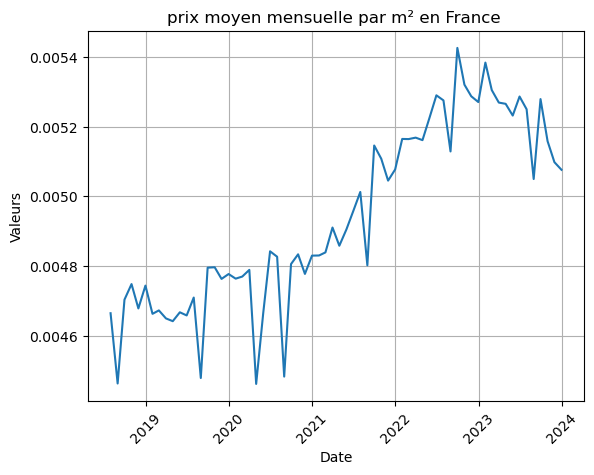

In [304]:
# Récupération de la colonne 3 pour en faire une série temporelle dans la variable serie_temporelle.
serie_temporelle = df_prix_moy_mois.iloc[:, 2]  

# Définir la date de départ et la fréquence mensuelle.
date_debut = '2018-07-01' 
frequence = 'M'

# Créer un indice de dates mensuelles à partir de la date de départ et de la longueur de la série temporelle
dates = pd.date_range(start=date_debut, periods=len(serie_temporelle), freq=frequence)

# Modification de l'indice de la série temporelles pour qu'il coresponde aux dates.
serie_temporelle.index = dates

# Représenter la série temporelle
plt.plot(serie_temporelle)
plt.xlabel('Date')
plt.ylabel('Valeurs')
plt.title('prix moyen mensuelle par m² en France ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Étude de la saisonnalité des prix immobiliers

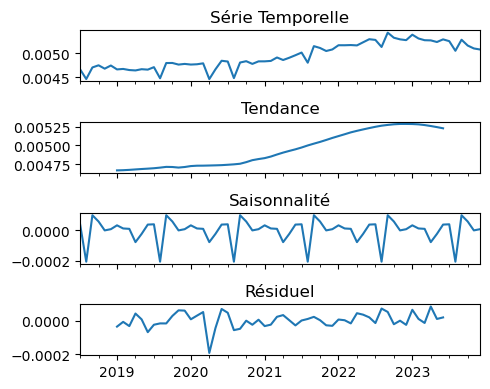

In [306]:
# Récupération de la fonction seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition saisonnière avec la fonction seasonal_decompose
resultats_decomposition = seasonal_decompose(serie_temporelle, model='additive')

# Visualiser les composantes :
fig, axes = plt.subplots(4, 1, figsize=(5, 4), sharex=True)

serie_temporelle.plot(ax=axes[0], title='Série Temporelle')
resultats_decomposition.trend.plot(ax=axes[1], title='Tendance')
resultats_decomposition.seasonal.plot(ax=axes[2], title='Saisonnalité')
resultats_decomposition.resid.plot(ax=axes[3], title='Résiduel')

plt.tight_layout()
plt.show()

# Les grands traits correspondent aux années, les petits aux trimestes.

## Relation entre le nombre de transactions et le nombre de pièces principales

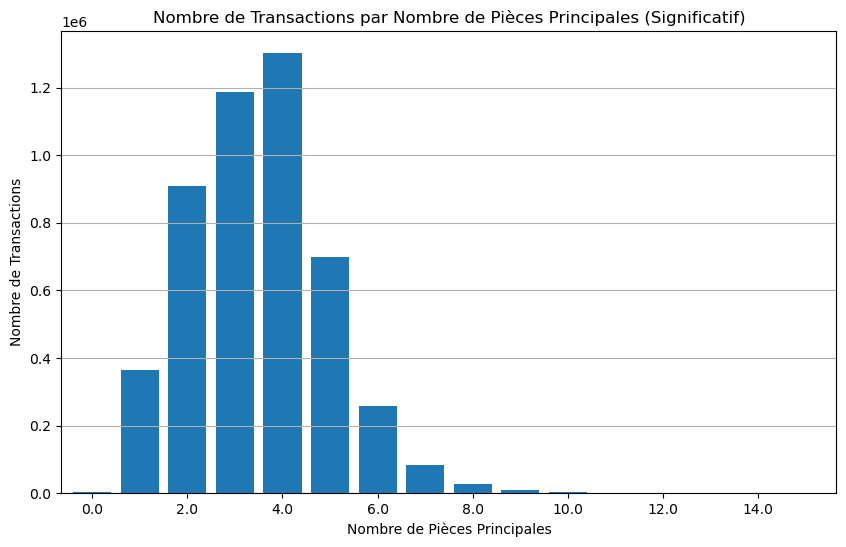

In [99]:
# Compter le nombre de transactions pour chaque nombre de pièces principales
nombre_de_transactions_par_pieces = df_scaled['Nombre pieces principales'].value_counts().sort_index()

# Définir un seuil pour filtrer les nombres de pièces principales insignifiants
# Par exemple, nous ne garderons que les catégories ayant plus de 100 transactions
seuil_transactions = 100
nombre_de_transactions_significatif = nombre_de_transactions_par_pieces[nombre_de_transactions_par_pieces > seuil_transactions]

# Créer l'histogramme pour les nombres de pièces principales significatifs
plt.figure(figsize=(10, 6))
nombre_de_transactions_significatif.plot(kind='bar', width=0.8)  # 'width' contrôle la largeur des barres

# Nommer les axes et le titre
plt.xlabel('Nombre de Pièces Principales')
plt.ylabel('Nombre de Transactions')
plt.title('Nombre de Transactions par Nombre de Pièces Principales (Significatif)')

# Améliorer la lisibilité des étiquettes de l'axe des abscisses
plt.xticks(rotation=0)  # Orientation verticale des étiquettes
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Afficher uniquement les valeurs entières

# Ajouter une grille pour une meilleure lisibilité
plt.grid(axis='y')

# Afficher l'histogramme
plt.show()


## Visualisation du niveau des prix sur la carte de France

In [293]:
# lien url pour récupérer les codes des départements et les noms
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"

# Lecture du fichier dans geopandas
metropole = geopandas.read_file(url)
metropole

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."
...,...,...,...
91,91,Essonne,"POLYGON ((2.22656 48.77610, 2.22866 48.77451, ..."
92,92,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
93,93,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
94,94,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."


In [286]:

# Dataframe merged, pour récupérer le prix au m² par département :
merged = prix_dep.merge(metropole, left_on="Code departement", right_on="code")
merged.set_index('code', inplace=True)
merged

,Code departement,Prix au m2,nom,geometry
code,,,,
01,01,2388.89,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
02,02,1336.21,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
03,03,1307.56,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
04,04,2246.00,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
05,05,2540.00,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."
...,...,...,...,...
92,92,6461.23,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
93,93,4000.00,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
94,94,4761.90,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."


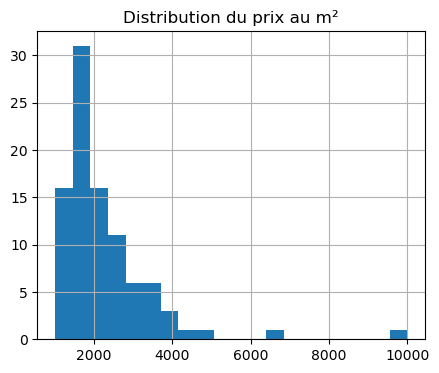

In [287]:
# Histogramme représentant la distribution du prix au m²

# affichage
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
merged.hist('Prix au m2', bins=20, ax=ax)
ax.set_title("Distribution du prix au m²");

In [288]:
# Ville les plus chère
ville_prix_élevé = merged.sort_values('Prix au m2').tail().iloc[:,0]

# Ville les moins chères et les plus chères :
ville_prix_bas = merged.sort_values('Prix au m2').head().iloc[:,0]
ville_prix_extrême = ville_prix_bas.tolist() + ville_prix_élevé.tolist()

In [289]:
# Visualisation des départements les plus chères de France dans le cadre de l'anyalyse géographique (pdf) 
merged.sort_values('Prix au m2').tail()

,Code departement,Prix au m2,nom,geometry
code,,,,
93,93,4000.00,Seine-Saint-Denis,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ..."
06,06,4206.35,Alpes-Maritimes,"MULTIPOLYGON (((7.06711 43.51365, 7.06665 43.5..."
94,94,4761.90,Val-de-Marne,"POLYGON ((2.33190 48.81701, 2.33371 48.81677, ..."
92,92,6461.23,Hauts-de-Seine,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ..."
75,75,10000.00,Paris,"POLYGON ((2.33190 48.81701, 2.33247 48.81825, ..."


In [297]:
# Conversion via geopanda pour réaliser la carte :
geomerged = geopandas.GeoDataFrame(merged)


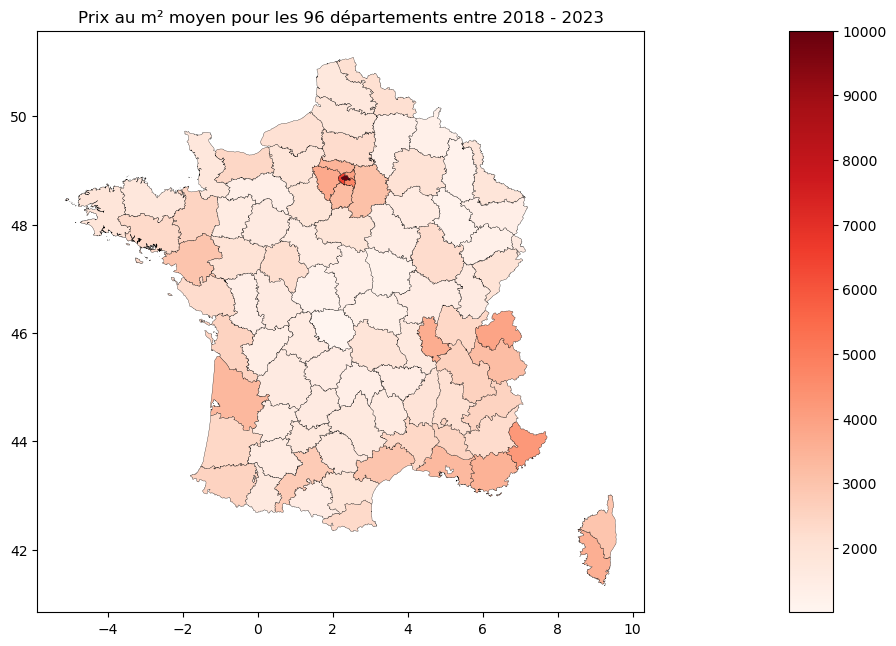

In [296]:
# Affichage de la carte de France avec le peix au m² par département :

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
#fig, ax = plt.subplots(1, 1)

# ligne à ajouter pour avoir une légende ajustée à la taille du graphe
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1)

geomerged.plot(column="Prix au m2", ax=ax, edgecolor='black', legend=True, cax=cax,linewidth=0.2,  cmap='Reds')
ax.set_title("Prix au m² moyen pour les %d départements entre 2018 - 2023" % metropole.shape[0]);

## Prix du mètre carré moyen par région et département:

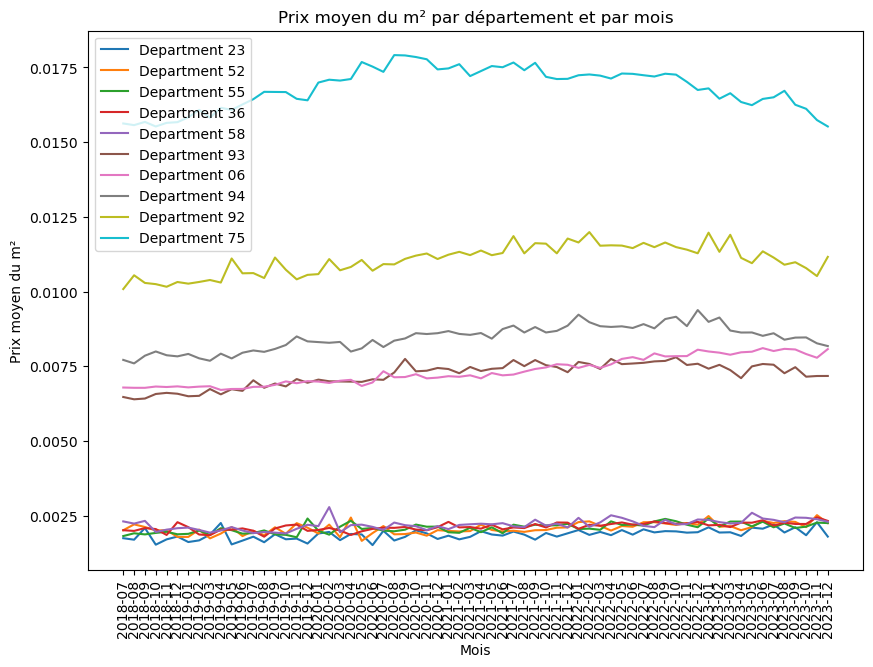

In [248]:
# Convertir 'Date mutation' en date et extraire par année et par mois avec .loc :

df_scaled['Date mutation'] = pd.to_datetime(df_scaled['Date mutation'])
df_scaled.loc[:, 'Year'] = df_scaled['Date mutation'].dt.year
df_scaled.loc[:, 'Month'] = df_scaled['Date mutation'].dt.month

# Regroupement par 'Code departement' et par année et mois, pour calculer le 'Prix au m2' moyen mensuel :
grouped = df_scaled.groupby(['Code departement', 'Year', 'Month'])['Prix au m2'].mean()

# Reset de l'indice 'Code departement', 'Year' and 'Month' :
grouped = grouped.reset_index()

# Afficher les résultats :
plt.figure(figsize=(10, 7))
for dept in ville_prix_extrême:
    dept_group = grouped[grouped['Code departement'] == dept]
    plt.plot(dept_group['Year'].astype(str) + '-' + dept_group['Month'].astype(str).str.zfill(2),
             dept_group['Prix au m2'], label=f'Department {dept}')

plt.xlabel('Mois')
plt.ylabel('Prix moyen du m²')
plt.title('Prix moyen du m² par département et par mois')
plt.legend()
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.show()


## Évolution des prix du mètre carré par région

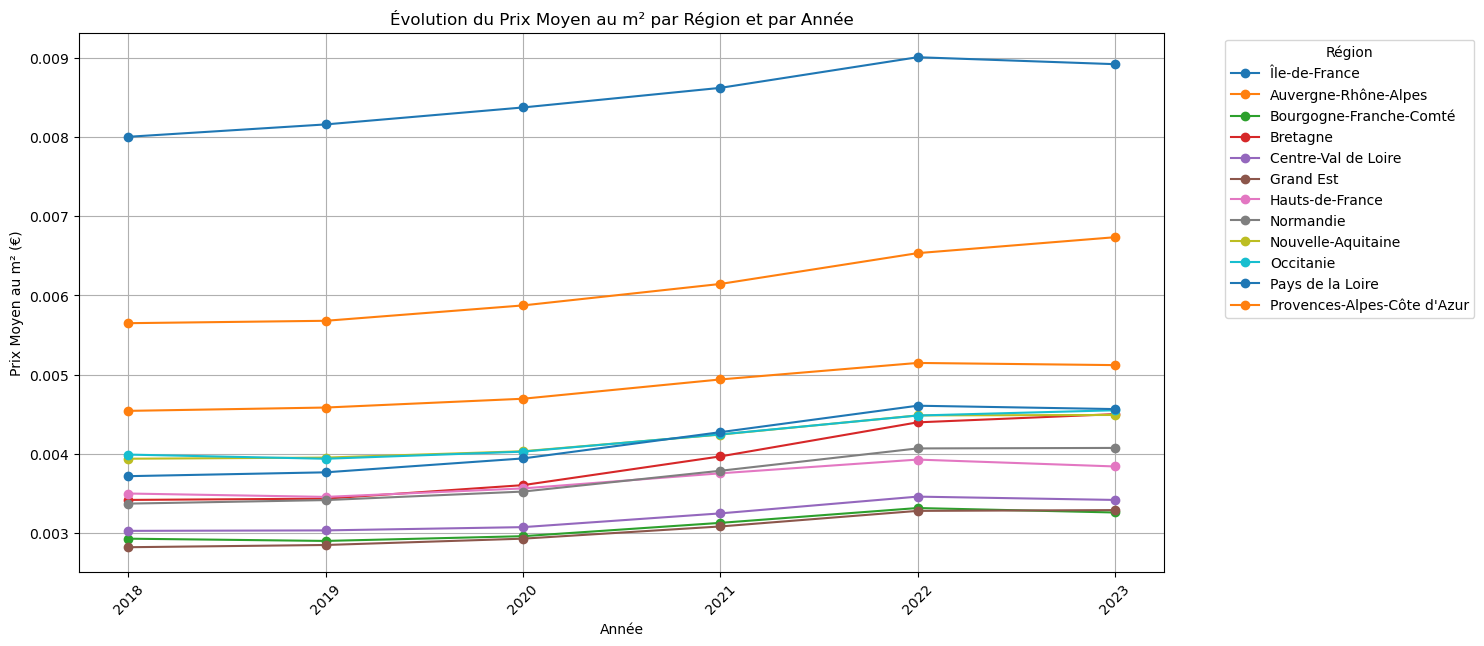

In [251]:
# création d'un département en région
regions = {
    'Île-de-France': ['75', '77', '78', '91', '92', '93', '94', '95'],
    'Auvergne-Rhône-Alpes': ['01', '03', '07', '15', '26', '38', '42', '43', '63', '69', '73', '74'],
    'Bourgogne-Franche-Comté': ['21', '25', '39', '58', '70', '71', '89', '90'],
    'Bretagne': ['22', '29', '35', '56'],
    'Centre-Val de Loire': ['18', '28', '36', '37', '41', '45'],
    'Grand Est': ['08', '10', '51', '52', '54', '55', '57', '67', '68', '88'],
    'Hauts-de-France': ['02', '59', '60', '62', '80'],
    'Normandie': ['14', '27', '50', '61', '76'],
    'Nouvelle-Aquitaine': ['16', '17', '19', '23', '24', '33', '40', '47', '64', '79', '86', '87'],
    'Occitanie': ['09', '11', '12', '30', '31', '32', '34', '46', '48', '65', '66', '81', '82'],
    'Pays de la Loire': ['44', '49', '53', '72', '85'],
    "Provences-Alpes-Côte d'Azur":['04', '05', '06', '13', '83', '84'] }



# Mapping département vers région
dept_to_region = {dept: region for region, depts in regions.items() for dept in depts}

# Ajout d'une colonne 'Region' basée sur le 'Code departement'
df_scaled['Region'] = df_scaled['Code departement'].map(dept_to_region)

# Calcul du prix moyen au m² par région et par année
price_per_m2_by_region_year = df_scaled.groupby(['Region', 'Year'])['Prix au m2'].mean().reset_index()

# Création d'un graphique
plt.figure(figsize=(14, 7))

# Tracé des lignes pour chaque région
for region in regions.keys():
    regional_data = price_per_m2_by_region_year[price_per_m2_by_region_year['Region'] == region]
    plt.plot(regional_data['Year'], regional_data['Prix au m2'], marker='o', label=region)

plt.title('Évolution du Prix Moyen au m² par Région et par Année')
plt.xlabel('Année')
plt.ylabel('Prix Moyen au m² (€)')
plt.legend(title='Région', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(regional_data['Year'].unique(), rotation=45)
plt.show()


## Évolution des prix de l'immobilier dans les départments frontaliers suisses :

###  a) Comparaison avec les 3 départements les plus chers de France :

C:\Users\vrbed\AppData\Local\Temp\ipykernel_22164\2510546851.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vrbed\AppData\Local\Temp\ipykernel_22164\2510546851.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vrbed\AppData\Local\Temp\ipykernel_22164\2510546851.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

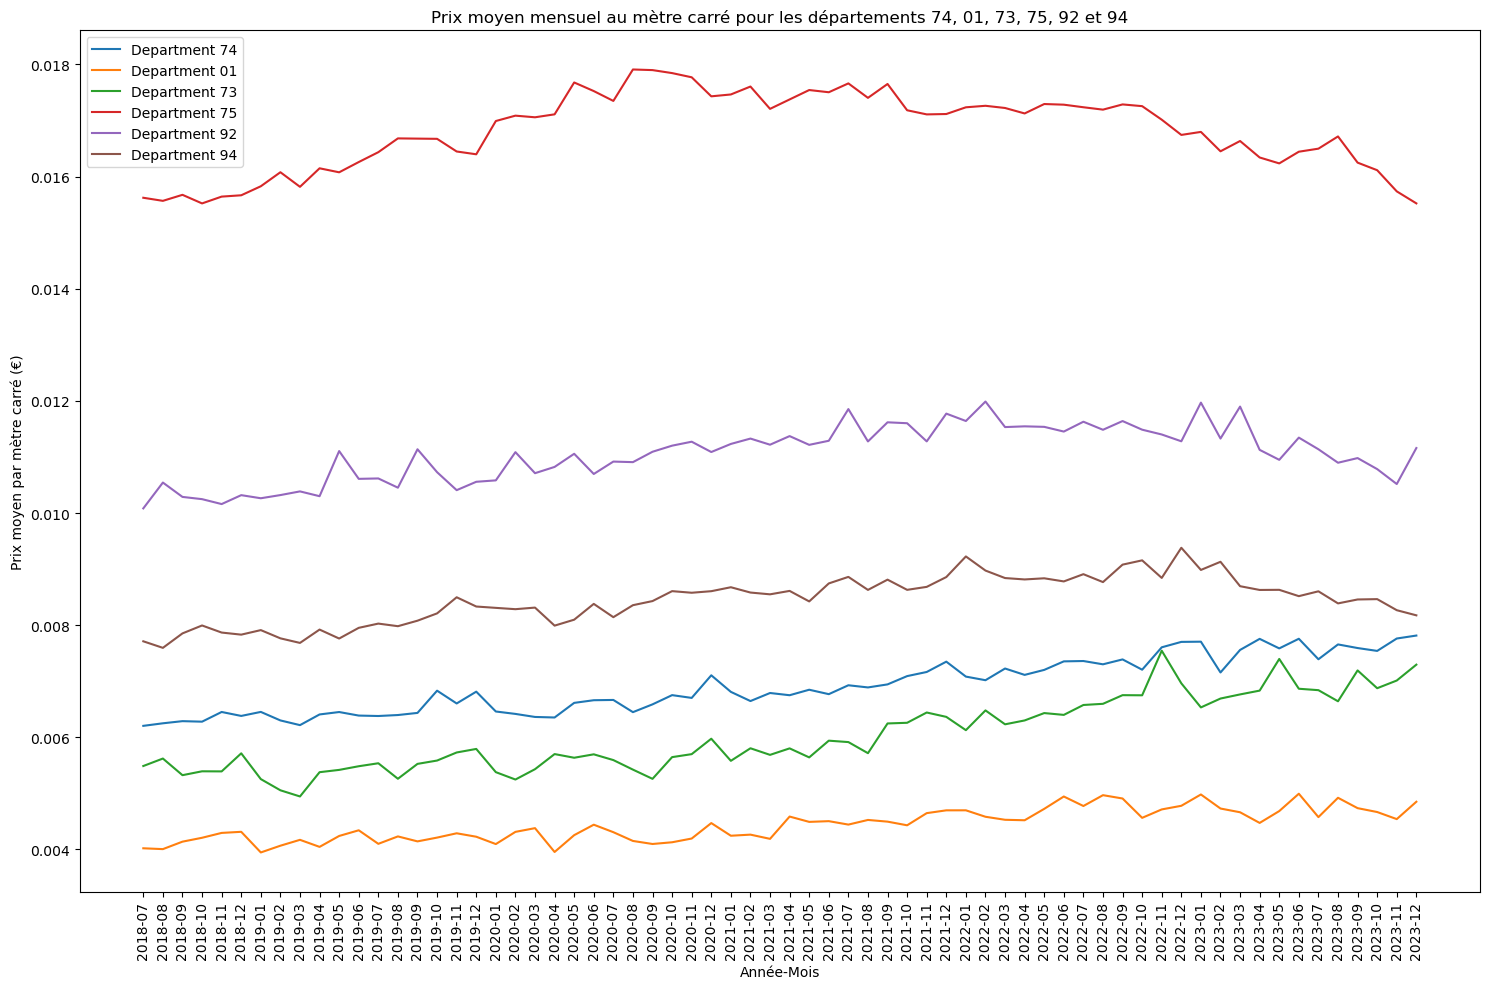

In [137]:
# Filtrer pour ne garder que les données des départements 74, 01, et 73
departments = ['74', '01', '73', '75', '92', '94']
df_filtered = df_scaled[df_scaled['Code departement'].isin(departments)]

# Assurer que les codes des départements sont de type string pour la visualisation
df_filtered['Code departement'] = df_filtered['Code departement'].astype(str)

# Convertir 'Date mutation' en type datetime si ce n'est pas déjà fait
df_filtered['Date mutation'] = pd.to_datetime(df_filtered['Date mutation'])

# Grouper les données par mois et par département et calculer le prix moyen
df_filtered['Year-Month'] = df_filtered['Date mutation'].dt.to_period('M').astype(str)
monthly_prices = df_filtered.groupby(['Year-Month', 'Code departement'])['Prix au m2'].mean().reset_index()

# Trier les données par mois pour le graphique
monthly_prices.sort_values(by='Year-Month', inplace=True)

# Créer un graphique
plt.figure(figsize=(15, 10))

# Tracer une ligne pour chaque département
for department in departments:
    df_dept = monthly_prices[monthly_prices['Code departement'] == department]
    plt.plot(df_dept['Year-Month'], df_dept['Prix au m2'], label=f'Department {department}')

plt.xlabel('Année-Mois')
plt.ylabel('Prix moyen par mètre carré (€)')
plt.title('Prix moyen mensuel au mètre carré pour les départements 74, 01, 73, 75, 92 et 94')
plt.legend()
plt.xticks(rotation=90)  # Améliorer la lisibilité des dates sur l'axe des abscisses
plt.tight_layout()  # Ajuster la mise en page pour tout afficher correctement
plt.show()

### b) Comparaison des prix immobiliers entre les départements frontaliers et l'île de France

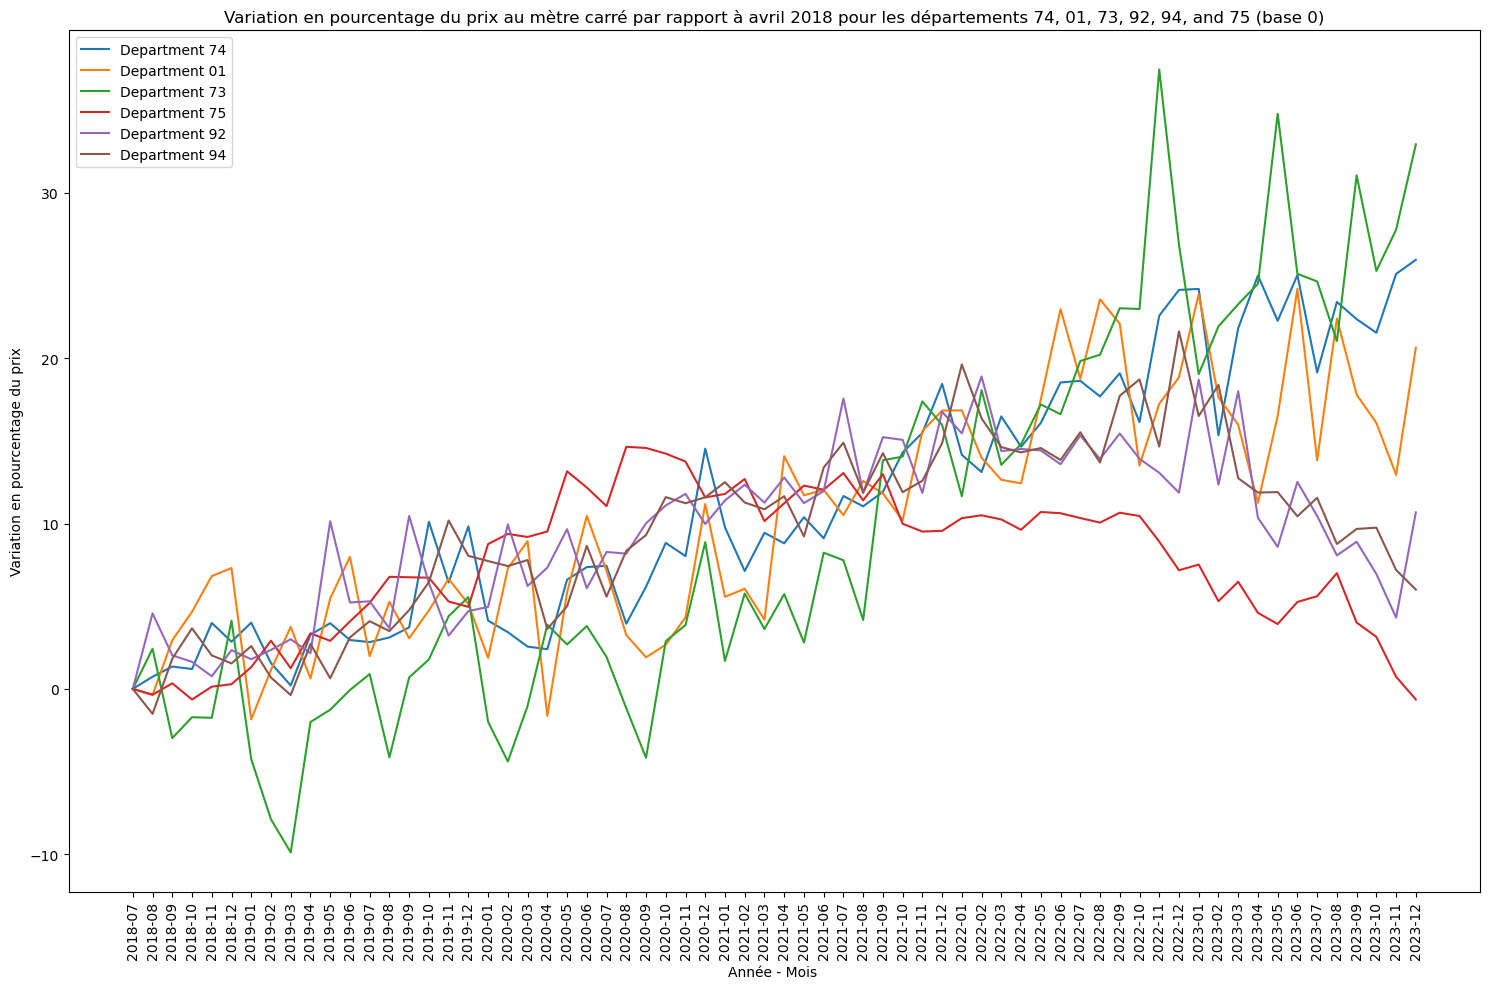

In [139]:
# Fonctions :

# Fonction pour calculer le pourcentage de changement
def calculate_percentage_change(row):
    baseline_price = baseline_prices.get(row['Code departement'], None)
    if baseline_price is not None and baseline_price != 0:
        return (row['Prix au m2'] - baseline_price) / baseline_price * 100
    else:
        return 0


# Main :

# Grouper les données par mois et par département et calculer le prix moyen
monthly_prices = df_filtered.groupby(['Year-Month', 'Code departement'])['Prix au m2'].mean().reset_index()

# Trier les données par mois pour le graphique
monthly_prices.sort_values(by='Year-Month', inplace=True)

# Calculer le prix de base en avril 2018 pour chaque département
baseline_prices = monthly_prices[monthly_prices['Year-Month'] == '2018-07'].set_index('Code departement')['Prix au m2']

# Appliquer la fonction pour calculer le pourcentage de changement
monthly_prices['Percentage Change'] = monthly_prices.apply(calculate_percentage_change, axis=1)

# Créer le graphique d'évolution des prix en pourcentage
plt.figure(figsize=(15, 10))

# Tracer une ligne pour chaque département
for department in departments:
    df_dept = monthly_prices[monthly_prices['Code departement'] == department]
    plt.plot(df_dept['Year-Month'], df_dept['Percentage Change'], label=f'Department {department}')

plt.xlabel('Année - Mois ')
plt.ylabel('Variation en pourcentage du prix')
plt.title('Variation en pourcentage du prix au mètre carré par rapport à avril 2018 pour les départements 74, 01, 73, 92, 94, and 75 (base 0)')
plt.legend()
plt.xticks(rotation=90)  # Améliorer la lisibilité des dates sur l'axe des abscisses
plt.tight_layout()  # Ajuster la mise en page pour tout afficher correctement
plt.show()

## Évolution du nombre de transactions par région

<Figure size 2000x1000 with 0 Axes>

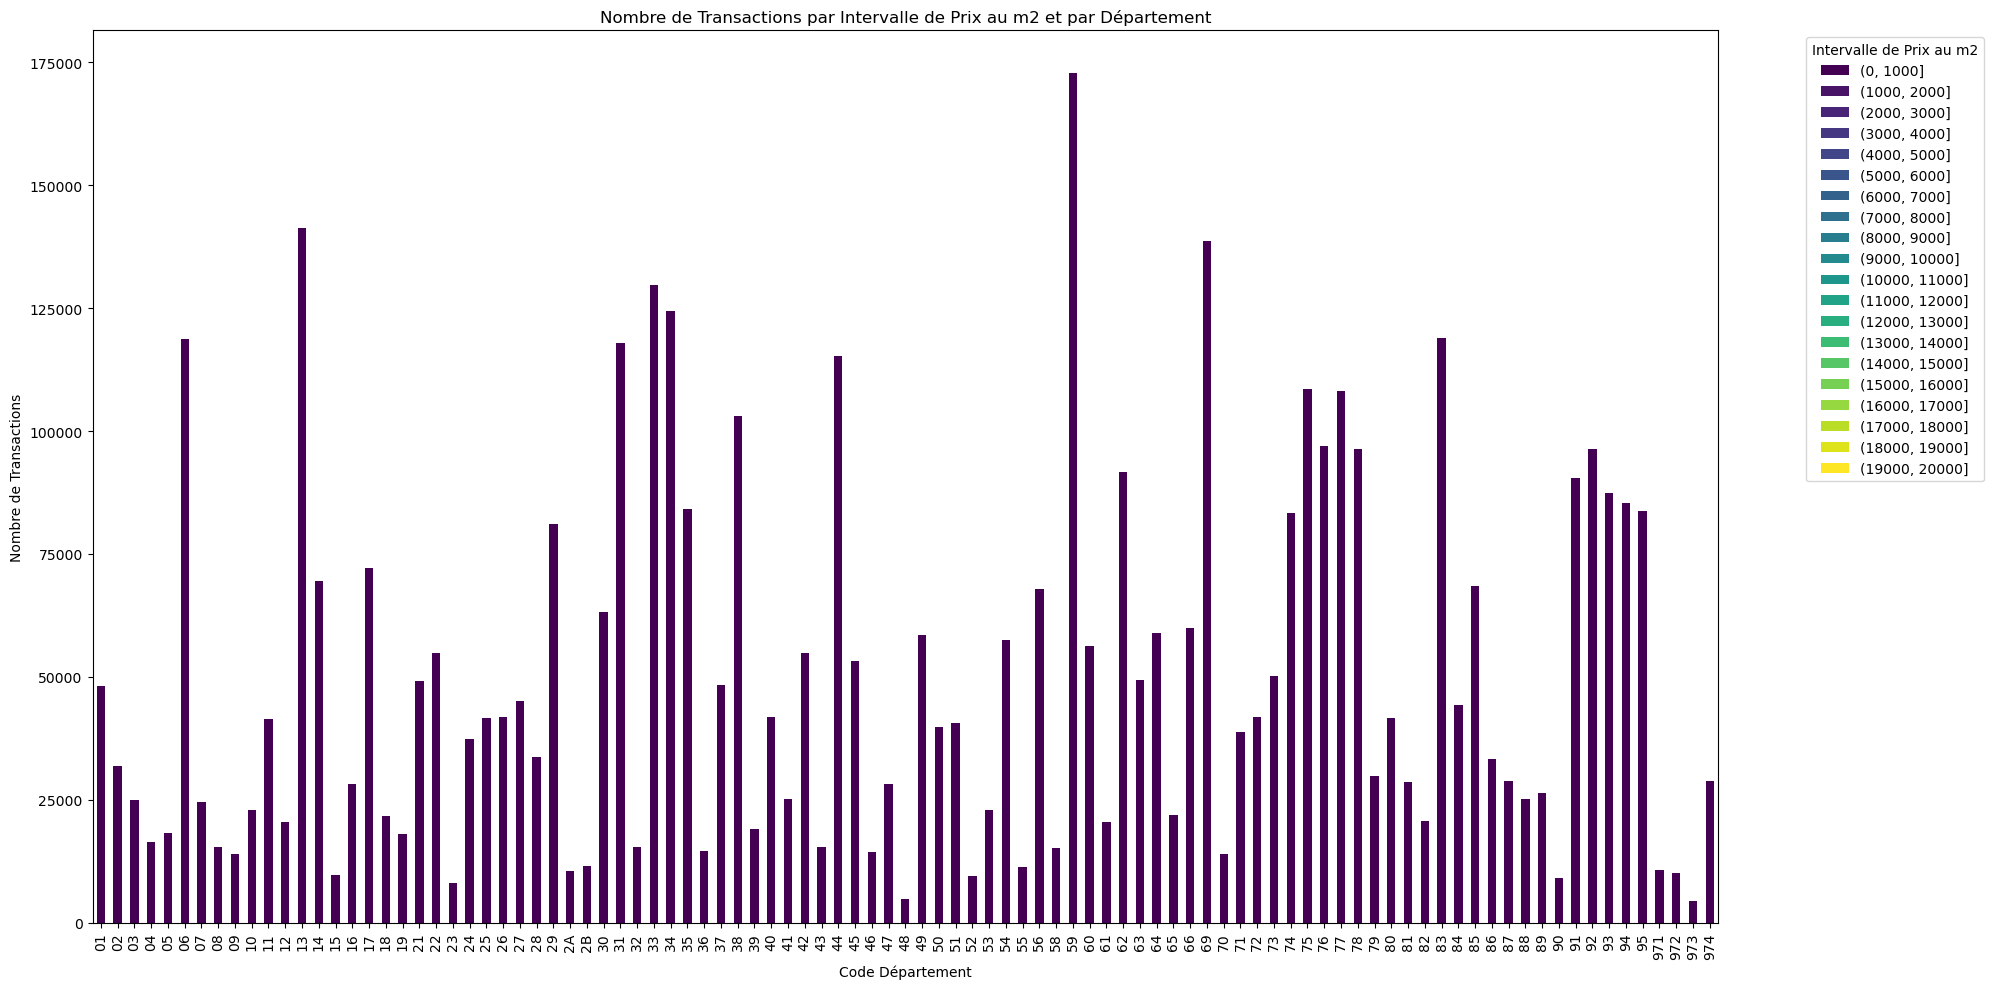

In [108]:
# Créer des intervalles de prix au mètre carré par tranche de 1000€
intervals = pd.interval_range(start=0, end=20000, freq=1000)
df_scaled['Price Interval'] = pd.cut(df_scaled['Prix au m2'], bins=intervals)

# Grouper par 'Code departement' et 'Price Interval'
grouped = df_scaled.groupby(['Code departement', 'Price Interval']).size().unstack(fill_value=0)

# Préparer le graphique
plt.figure(figsize=(20, 10))

# Créer un heat map ou un stacked bar plot

# Pour un stacked bar plot, décommentez les lignes suivantes:
grouped.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='viridis')
plt.title('Nombre de Transactions par Intervalle de Prix au m2 et par Département')
plt.xlabel('Code Département')
plt.ylabel('Nombre de Transactions')
plt.legend(title='Intervalle de Prix au m2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

# Afficher le graphique
plt.show()


<Figure size 2000x1000 with 0 Axes>

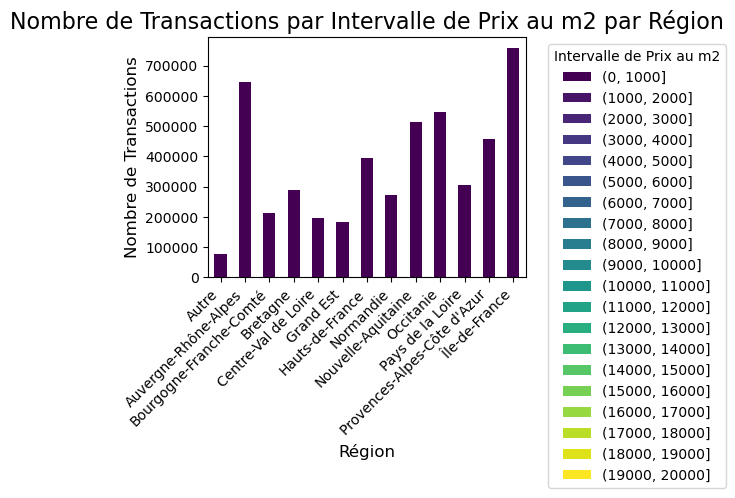

In [255]:



# Fonction pour obtenir la région à partir du code département
def get_region(dept_code):
    for region, depts in regions.items():
        if dept_code in depts:
            return region
    return 'Autre'  # Pour les codes département non trouvés
intervals = pd.interval_range(start=0, end=50000, freq=1000)
# Créer une nouvelle colonne 'Region' dans le DataFrame
df_scaled['Region'] = df_scaled['Code departement'].apply(get_region)

# Grouper les données par 'Region' et 'Price Interval'
grouped_by_region = df_scaled.groupby(['Region', 'Price Interval']).size().unstack(fill_value=0)

# Préparer le graphique
plt.figure(figsize=(20, 10))

# Créer un stacked bar plot par région
grouped_by_region.plot(kind='bar', stacked=True, colormap='viridis')

# Réglages du titre et des étiquettes
plt.title('Nombre de Transactions par Intervalle de Prix au m2 par Région', fontsize=16)
plt.xlabel('Région', fontsize=12)
plt.ylabel('Nombre de Transactions', fontsize=12)

# Ajustement de la légende
plt.legend(title='Intervalle de Prix au m2', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Ajuster automatiquement le layout
plt.tight_layout()

# Afficher le graphique
plt.show()

## Evolution du nombre de transactions par région et par année

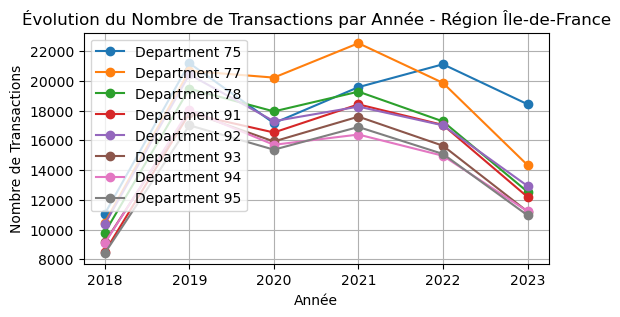

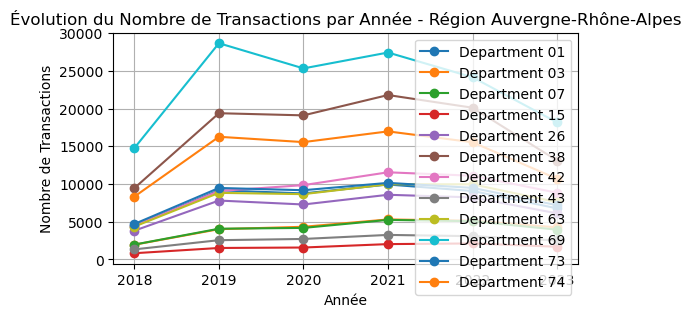

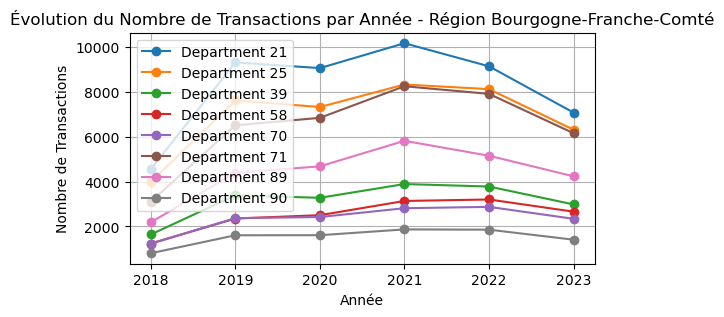

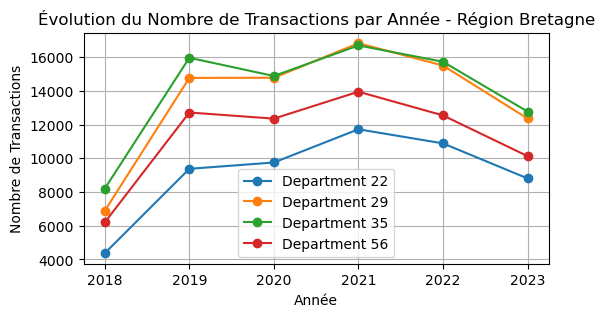

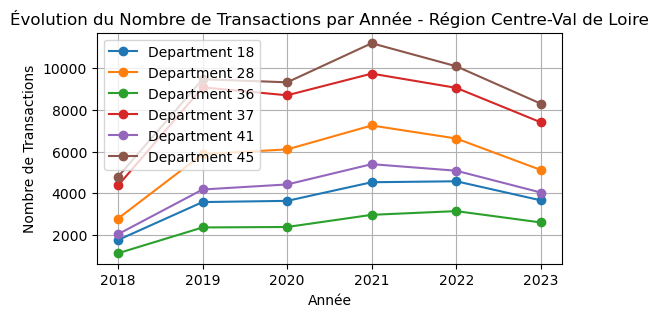

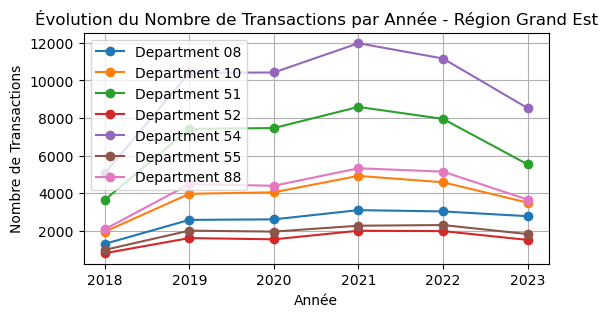

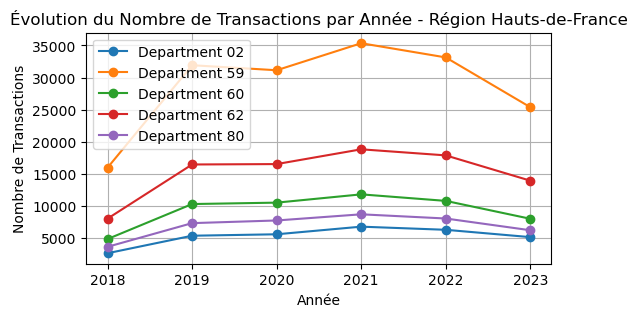

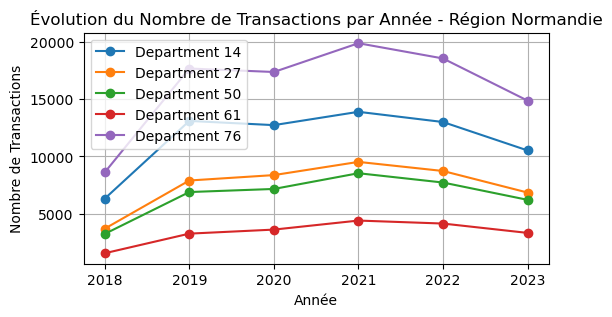

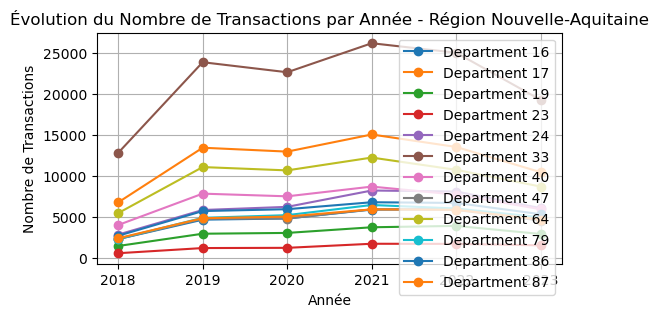

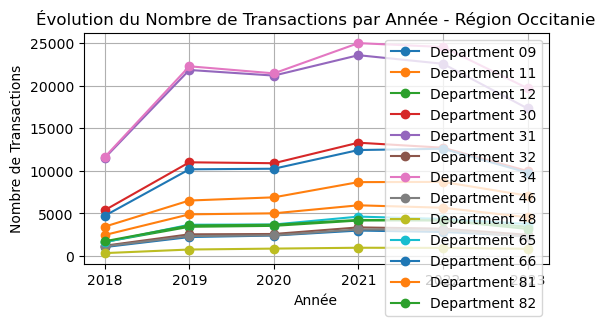

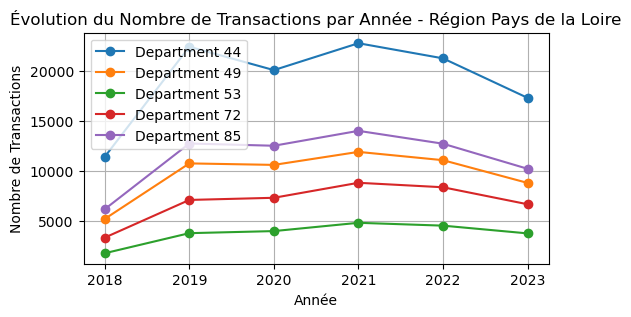

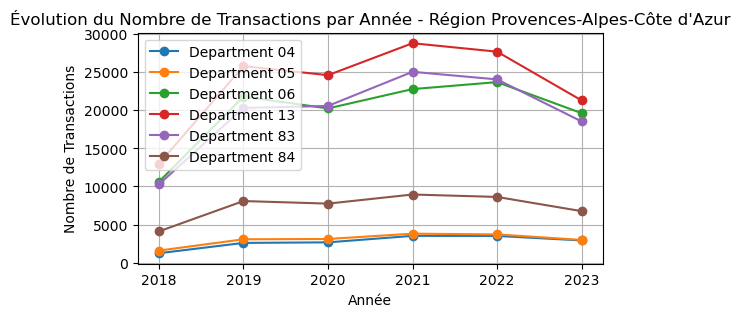

In [114]:


# Assurez-vous que la colonne 'Code departement' est du bon type
df_scaled['Code departement'] = df_scaled['Code departement'].astype(str)

# Convertir 'Date mutation' en type datetime et extraire l'année
df_scaled['Date mutation'] = pd.to_datetime(df_scaled['Date mutation'])
df_scaled['Year'] = df_scaled['Date mutation'].dt.year

# Calculer le nombre de transactions par année pour chaque département
df_transactions_by_year = df_scaled.groupby(['Code departement', 'Year']).size().reset_index(name='Transactions')

# Créer un graphique pour chaque région
for region_name, dept_list in regions.items():
    # Filtrer les données pour inclure seulement les départements de la région actuelle
    df_region = df_transactions_by_year[df_transactions_by_year['Code departement'].isin(dept_list)]
    
    # Plot
    plt.figure(figsize=(6, 3))
    for dept in dept_list:
        if dept in df_region['Code departement'].values:
            df_dept = df_region[df_region['Code departement'] == dept]
            plt.plot(df_dept['Year'], df_dept['Transactions'], marker='o', label=f'Department {dept}')
    
    plt.title(f'Évolution du Nombre de Transactions par Année - Région {region_name}')
    plt.xlabel('Année')
    plt.ylabel('Nombre de Transactions')
    plt.legend()
    plt.grid(True)
    plt.xticks(df_region['Year'].unique())
    plt.show()


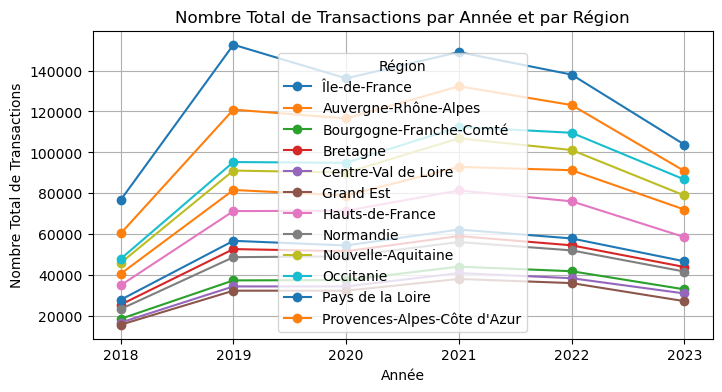

In [115]:


# Inverser le dictionnaire pour obtenir un mappage département à région
dept_to_region = {dept: region for region, depts in regions.items() for dept in depts}

# Assurez-vous que 'Code departement' est une chaîne de caractères
df_scaled['Code departement'] = df_scaled['Code departement'].astype(str)

# Créer une nouvelle colonne 'Region' basée sur 'Code departement'
df_scaled['Region'] = df_scaled['Code departement'].map(dept_to_region)

# Grouper les données par région et par année, et sommer les transactions
transactions_by_region_year = df_scaled.groupby(['Region', 'Year']).size().reset_index(name='Transactions')

# Créer le graphique
plt.figure(figsize=(8, 4))

for region in regions.keys():
    df_region = transactions_by_region_year[transactions_by_region_year['Region'] == region]
    plt.plot(df_region['Year'], df_region['Transactions'], marker='o', label=region)

plt.title('Nombre Total de Transactions par Année et par Région')
plt.xlabel('Année')
plt.ylabel('Nombre Total de Transactions')
plt.legend(title='Région')
plt.grid(True)
plt.xticks(df_region['Year'].unique())
plt.show()


## Analyse du rapport prix au m² par densité et par département :

In [261]:
# récupéreration du fichier des densités

# Code permettant de selectionner un dossier et de le définir comme répertoire de travail pour importer les fichiers de données utilisés dans l'étude

root = tk.Tk()
root.withdraw() 
path = filedialog.askdirectory()
chemin = path + '/densite2.xlsx'
print(chemin)


C:/Users/vrbed/OneDrive/Documents/Dauphine/M1/S8/Data management/densite/densite2.xlsx


In [262]:

# Charger les données de densité de population dans un DataFrame
df_densite = pd.read_excel(chemin)
df_densite.iloc[:, 0] = df_densite.iloc[:, 0].astype(str)
for i in range(1,10) :
    df_densite.iloc[i-1,0] = f'0{i}'
df_densite.columns = ['Code departement','département','dens_pop']
df_densite

,Code departement,département,dens_pop
0,01,Ain,114.16
1,02,Aisne,71.91
2,03,Allier,45.73
3,04,Alpes-de-Haute-Provence,23.89
4,05,Hautes-Alpes,25.34
...,...,...,...
96,971,Guadeloupe,235.54
97,972,Martinique,320.23
98,973,Guyane,3.41
99,974,La Réunion,344.72


In [263]:

# Fusionner le dataframe merged (qui contient la moyenne des prix au m² par departement) et le dataframe df_densite (qui contient la densité par departement)
df_merged = pd.merge(merged, df_densite, on='Code departement')

# Mesurer la corrélation entre les prix et la densité 
correlation = df_merged['dens_pop'].corr(df_merged['Prix au m2'])

# Afficher la corrélation entre les prix et la densité
print("Corrélation entre colonne1 et colonne2 :", correlation)

# Modèle de régression linéaire simple de la densité sur les prix au m² moyen des département de FRance, 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Variables
Px = df_merged['Prix au m2'].values.reshape(-1, 1)
dens = df_merged['dens_pop'].values.reshape(-1, 1)

# modèle
model = LinearRegression()

# fit
model.fit(Px, dens)

# Calcul du coefficient de détermination (R²)
r_squared = model.score(Px, dens)

print("Coefficient de détermination (R²) :", r_squared)

Corrélation entre colonne1 et colonne2 : 0.821535719223403
Coefficient de détermination (R²) : 0.6749209379599141


# 3. Impact des taux d'intérêt sur le marché immobilier résidentiel : 

In [325]:
# récupéreration du fichier des taux

# Code permettant de selectionner un dossier et de le définir comme répertoire de travail pour importer les fichiers de données utilisés dans l'étude

root = tk.Tk()
root.withdraw()  
path = filedialog.askdirectory()
print("Dossier sélectionné :", path)
os.chdir(path)

#Importation de fichier des taux
files = [os.path.join(path, file) for file in os.listdir(path)]

#Concaténation des fichiers pour récupérer la totalité des observations dans un dataframe
df_rate = pd.concat((pd.read_csv(file, sep = ",", header=0,low_memory=False) for file in files), sort=False)



Dossier sélectionné : C:/Users/vrbed/OneDrive/Documents/Dauphine/M1/S8/Data management/taux d'interet


In [326]:
# Ajout de la colonne des taux d'intérêt au dataframe retraité: 


df_rate['DATE'] = pd.to_datetime(df_rate['DATE'], errors='coerce')
df_rate.rename(columns={'DATE': 'Date mutation', 'IRLTLT01FRM156N': 'Interest Rate'}, inplace=True)
merged_data = pd.merge(df_scaled, df_rate, on='Date mutation', how='inner')

# drop les valeurs dupliqués: 
merged_data.dropna(subset=['Valeur fonciere', 'Prix au m2', 'Interest Rate'], inplace=True)


In [327]:
# Observation du dataframe
merged_data.head()

,Date mutation,Valeur fonciere,Code departement,Type local,Nature mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Prix au m2,Year,Month,key,Price Interval,Region,Interest Rate
0,2019-02-01,0.082758,01,0,Vente,0.000164,0.023093,3.0,0.002629,2019,2,442775,"(0, 1000]",Auvergne-Rhône-Alpes,0.54975
1,2019-02-01,0.356474,01,0,Vente,0.000164,0.042474,4.0,0.003936,2019,2,442816,"(0, 1000]",Auvergne-Rhône-Alpes,0.54975
2,2019-02-01,0.405172,01,0,Vente,0.000164,0.023093,2.0,0.008062,2019,2,445149,"(0, 1000]",Auvergne-Rhône-Alpes,0.54975
3,2019-02-01,0.572931,01,1,Vente,0.000333,0.043711,4.0,0.005767,2019,2,445188,"(0, 1000]",Auvergne-Rhône-Alpes,0.54975
4,2019-02-01,0.294051,01,1,Vente,0.000046,0.044948,5.0,0.003173,2019,2,445198,"(0, 1000]",Auvergne-Rhône-Alpes,0.54975


## Analyse temporelle des taux d'intérêts :

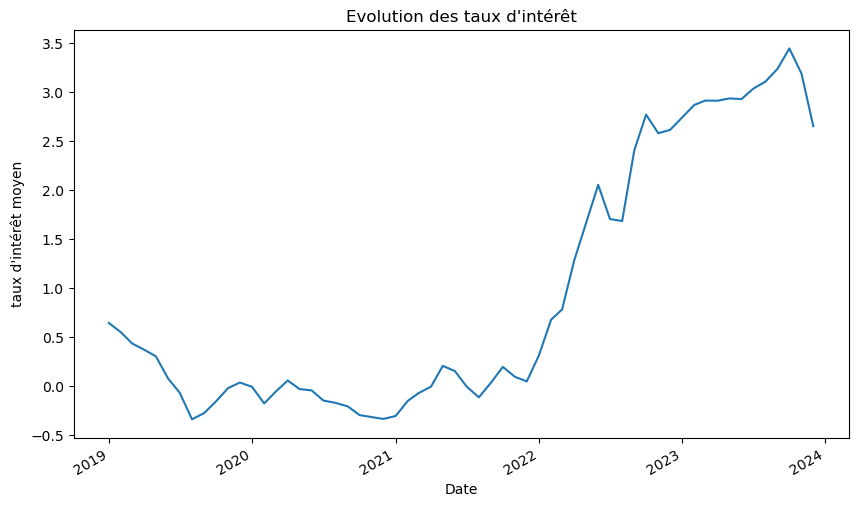

In [328]:
# Evolution de taux d'interet
plt.figure(figsize=(10, 6))
merged_data.groupby('Date mutation')['Interest Rate'].mean().plot()
plt.title("Evolution des taux d'intérêt")
plt.xlabel('Date')
plt.ylabel("taux d'intérêt moyen")
plt.show()

## Comparaison entre l'évolution des taux et la dynamique des transactions immobilières 

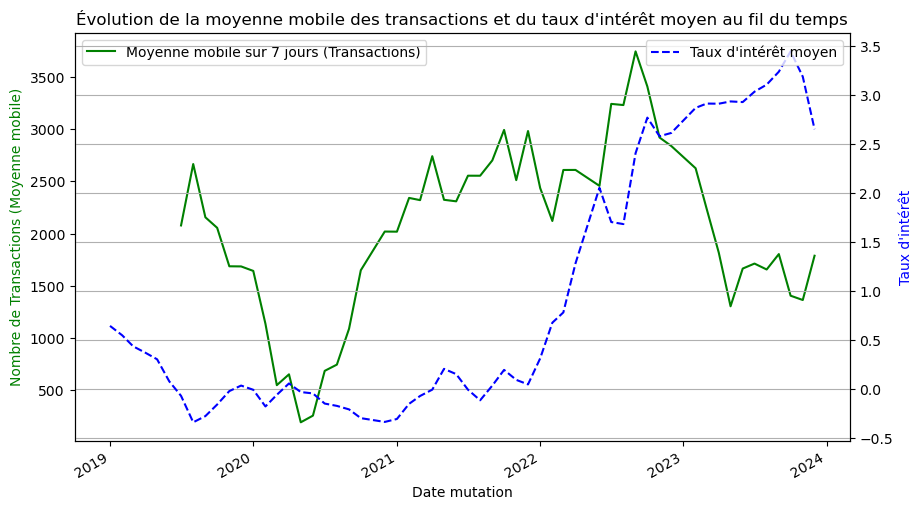

In [333]:
# Calculer la moyenne mobile sur le nombre de transactions
taille = 7  # Taille de la fenêtre pour la moyenne mobile
moyenne_mobile_transactions  = merged_data.groupby('Date mutation').size().rolling(window=taille).mean()

# Tracer le graphique avec la moyenne mobile et les taux d'intérêt
fig, ax1 = plt.subplots(figsize=(10, 6))


# Mise en forme du graphique

ax2 = ax1.twinx()
moyenne_mobile_transactions.plot(ax=ax1, color='green', label=f'Moyenne mobile sur {window_size} jours (Transactions)')
merged_data.groupby('Date mutation')['Interest Rate'].mean().plot(ax=ax2, color='b', label='Taux d\'intérêt moyen', linestyle='--')

ax1.set_ylabel('Nombre de Transactions (Moyenne mobile)', color='green')
ax2.set_ylabel('Taux d\'intérêt', color='b')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xlabel('Date')
plt.title('Évolution de la moyenne mobile des transactions et du taux d\'intérêt moyen au fil du temps')
plt.grid(True)
plt.show()


## Comparaison du taux d'intérêt avec la dynamique des prix du marché immobilier

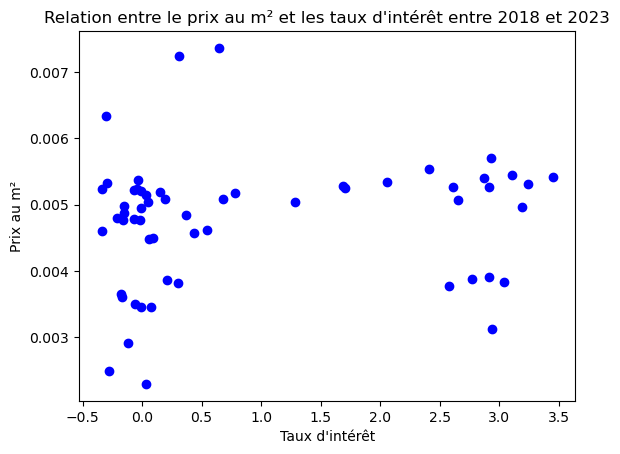

In [336]:

# Filtrer les données pour le département 75
df_paris = merged_data


# Calculer la moyenne des prix au mètre carré et des taux d'intérêt par mois
moyenne_paris_par_mois = df_paris.groupby(['Year', 'Month']).agg({'Prix au m2': 'mean', 'Interest Rate': 'mean'}).reset_index()

# Créer le graphique
fig, ax = plt.subplots()

ax.scatter(moyenne_paris_par_mois['Interest Rate'], moyenne_paris_par_mois['Prix au m2'], marker='o', color='b')

# Ajouter des étiquettes et un titre
ax.set_xlabel('Taux d\'intérêt')
ax.set_ylabel('Prix au m²')
ax.set_title('Relation entre le prix au m² et les taux d\'intérêt entre 2018 et 2023')


# Afficher le graphique
plt.show()

# 4. Evolution des variables pertinentes pour modéliser l'évolution des prix

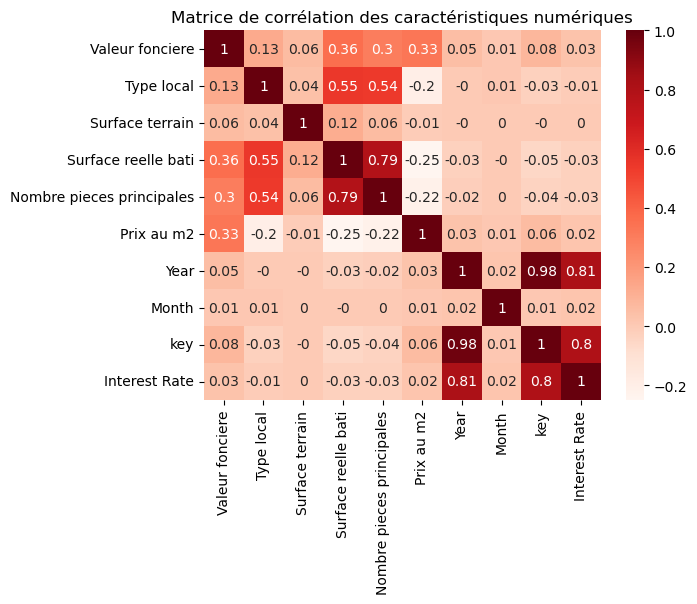

In [337]:
# Exclure les colonnes non numériques pour l'analyse de corrélation
numeric_cols = merged_data.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

# Tracer la matrice de corrélation

sns.heatmap(round(corr_matrix,2), annot=True, cmap='Reds')

plt.title('Matrice de corrélation des caractéristiques numériques')
plt.show()

# 5 . Prédiction des prix par un modèle de Machine Learning

In [368]:
# Importation des libairies pour tester le modèle de ML

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [370]:
# Fonctions permettant de récupérer la valeur prédite par le modèle et de calculer sa précision / l'erreur d'estimation

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    accuracy = model.score(test_features, test_labels)

    print('Average Error  = {:0.4f} degrees'.format(np.mean(errors)))
    print('Model Accuracy = {:0.4f} %'.format(accuracy))

In [371]:
# Tri de la matrice de corrélation en ordre décroissant
correlation_with_target = corr_matrix['Valeur fonciere'].sort_values(ascending=False)

# Sélection des variables le plus corrélé avec les valeurs foncières       
selected_features = ['Surface reelle bati','Nombre pieces principales']
X = merged_data[selected_features]
y =  merged_data['Valeur fonciere']

In [372]:
print(correlation_with_target)
# Les correlations les plus importantes sont ; 'Surface reelle bati','Prix au m2','Nombre pieces principales'
# C'est à partir de ces données que l'on entraine le modèle

Valeur fonciere              1.000000
Surface reelle bati          0.357322
Prix au m2                   0.327579
Nombre pieces principales    0.299539
Type local                   0.125144
key                          0.080815
Surface terrain              0.056573
Year                         0.052202
Interest Rate                0.034600
Month                        0.013541
Name: Valeur fonciere, dtype: float64


In [374]:

# Fonction train_test_split pour obtenir X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 12)


In [375]:
dt = DecisionTreeRegressor(min_samples_split=2)
dt.fit(X_train, y_train)

print("Training Accuracy = ", dt.score(X_train, y_train))
print("Test Accuracy     = ", dt.score(X_test, y_test))

Training Accuracy =  0.16494820329632598
Test Accuracy     =  0.1249857751440887


In [376]:
evaluate(dt, X_train, y_train)

Average Error  = 0.1507 degrees
Model Accuracy = 0.1649 %


In [377]:
evaluate(dt, X_test, y_test)

Average Error  = 0.1540 degrees
Model Accuracy = 0.1250 %


### Visualisation des résultats :

In [380]:
pred = dt.predict(X_test)

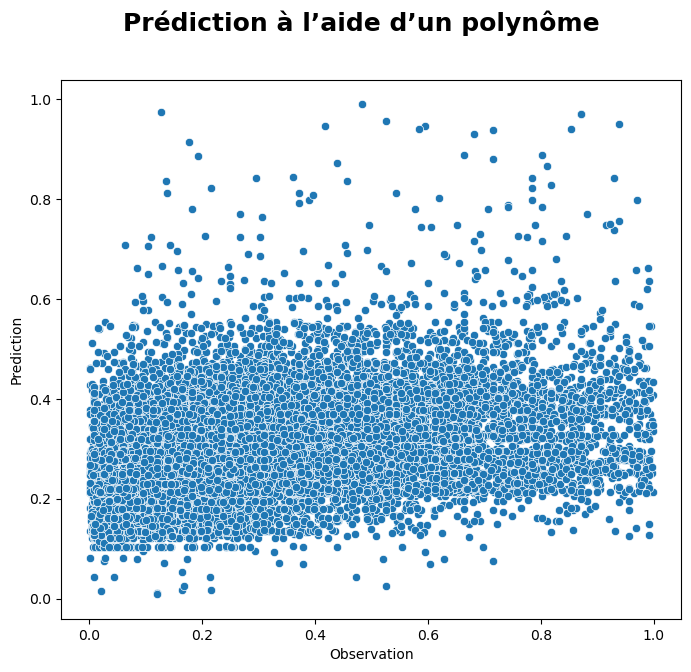

In [379]:
fig = plt.figure(figsize=(8,7))

sns.scatterplot(x = y_test, y = pred)
fig.suptitle('Prédiction à l’aide d’un polynôme', fontsize= 18 , fontweight='bold')
plt.xlabel("Observation")
plt.ylabel("Prediction")

plt.show()